# Geometrik Aralıklı Sınıflandırma 
### (Geometric Interval Classification)

Geomerik serinin genel formu aşağıdaki şekilde tanımlanır.
<br>
$$a, ar, ar^{2}, ar^{3}, ... , ar^{n-1}$$
<br>
Burada bir verş setini geometrik seri açılımından faydalanarak 0 ile 100 değerleri arasında $n$ adet sınıfta tanımlayacağız. 

In [1]:
# Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import copy

%matplotlib inline

**Geometrik aralıklı sınıflandırma işlemi sabitleri**
<br>
<br>
Kullanıcıdan yalnızca sınıf sayısı ($n$) istenir. Diğer değerler hesaplanır. 
<br>
<br>
Sabit değerin ($a$) bulunması için iteratif bir çözüm uydurulmuştur. Verilerin dağılımı içerisinde 1'in sınıf sayısına bölünmesiyle elde edilen yüzdelik dilimin üstel ifade ($r$) ile çarpılması iteratif olarak çözülür. Belirlenen hata mertebesinden mertebesinden küçük olana kadar bu çözüme devam edilir.
<br>
Bilgi: https://www-users.york.ac.uk/~mb55/intro/quantile.htm
<br>
$$\frac{1}{n} \rightarrow Q$$
<br>
$$a_1={r_1}{Q_1}\;\;\;...\;\;\;a_m={r_m}{Q_m} \;\; (Error<10^{-5})$$
<br>
$$Error = \frac{|a_m - a_{m-1}|}{a_m}$$
<br>
<br>
Üstel ifadeyi ($r$) bulmak için veri setinin maksimum değeri en büyük sınıf değeri olarak belirlenir.
<br>
$$ar^{n-1}=max(Data)$$
<br>
Bu ifadeden $r$ değeri çekilir.
<br>
$$r=\sqrt[n-1]{\frac{max(Data)}{a}}$$

In [2]:
"""
Geometrik aralıklı sınıflandırma fonksiyonu

Değişkenler:
 df: dataframe
 classNumber: Kaç adet sınıf kullanılacağı (n)
 constant: Serideki sabit değer (a)
 rValue: Üstel ifade (r)
"""
    
def gi_classify(df, classNumber):  
    try:
        constantOld = 1e20
        rValue = 1
        error = 1e-5
        
        # Not: İteratif olarak constant hesaplama yöntemi uydurdum.
        for i in range(0, 999):
            constant = rValue * df.Intensity.quantile(1 / classNumber)
            rValue = (df.Intensity.max() / constant) ** (1 / (classNumber - 1))   

            plt.scatter(i, constant, color="blue")
        
            if (abs(constantOld - constant) / constant <= error ):
                break
        
            constantOld = constant
        
        plt.xlabel("İterasyon")
        plt.ylabel("Constant değeri")
        plt.show()
        
    except RuntimeWarning:
        # Değerler 0'a yakınsarsa constant'a sabit bir sayı atanır.
        constant = 10000
        rValue = (df.Intensity.max() / constant) ** (1 / (classNumber - 1))   
    
    print("classNumber: {}".format(classNumber))
    print("constant: {}".format(constant))
    print("rValue: {}".format(rValue))
    
    """
    quantile işlevi JavaScript'te mevcut değilse onun fonksiyonunu ayrı 
    yazabiirim ya da constant değerini de classify fonksiyonuna input olarak 
    verebiliriz.
    """
    
    dfCopy = copy(df)
    dfCopy.Intensity = 0
    
    classes = []
    percentages = []
    
    # Sınıf değerleri ve yüzde aralıkları oluşturulur.
    for i in range(0, classNumber):
        classes.append(constant * (rValue ** i))
        percentages.append(i * (100 / classNumber))
    
    print("Classes: {}".format(classes))
    print("Percentages: {}".format(percentages))
    
    # Eşdeğer yüzdesel değerler dfCopy içerisine aktarılır.
    for i in range(classNumber - 1, -1, -1):    
        dfCopy.Intensity = np.where(df.Intensity <= classes[i], percentages[i], dfCopy.Intensity)
        
    return dfCopy


         Lat       Lon   Intensity
0  45.686083  8.550842    0.000000
1  45.686083  8.730505    0.134601
2  45.686083  8.910168  148.267476
3  45.686083  9.089832  600.396757
4  45.686083  9.269495  844.344459


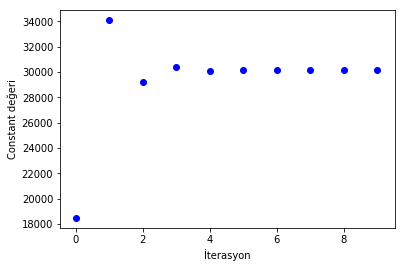

classNumber: 5
constant: 30157.44476349069
rValue: 1.6327724553848701
Classes: [30157.44476349069, 49240.245134618286, 80398.11595220362, 131271.82919159697, 214337.02687202708]
Percentages: [0.0, 20.0, 40.0, 60.0, 80.0]


In [3]:
# Veri seti
fileName = "lightning_heat_map_austria.csv"
df = pd.read_csv(fileName)

print(df.head())

# Sınıf sayısı
classNumber = 5

# Sınıflandır
classified_df = gi_classify(df, classNumber)


In [4]:
# Sınıflandırılmış dataframe
print(classified_df.head())

# Dosyaya yazdır
classified_df.to_csv("classified_" + fileName, index=None)


         Lat       Lon  Intensity
0  45.686083  8.550842        0.0
1  45.686083  8.730505        0.0
2  45.686083  8.910168        0.0
3  45.686083  9.089832        0.0
4  45.686083  9.269495        0.0


**Linkler:**
<br>
<br>
https://en.wikipedia.org/wiki/Geometric_progression
<br>
http://wiki.gis.com/wiki/index.php/Geometric_Interval_Classification
<br>
https://pro.arcgis.com/en/pro-app/help/mapping/layer-properties/data-classification-methods.htm